# Predicting E-commerce Customer Behavior
## University of San Diego
## ADS 508 Data Science Cloud Computing 
## Team 5: Trevor Sauerbrey, Jiaqi He, Summer Purschke

In [1]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
import io
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from pyathena import connect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# ML 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, \
RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report, adjusted_rand_score, \
r2_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sagemaker.tuner import HyperparameterTuner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from scipy.stats import loguniform
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.utils import resample
import datetime
import random

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'wordcloud'

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Ingest Data From S3

In [3]:
ingest_create_athena_db_passed = False

In [4]:
# set a database name
database_name = "ecommerce"

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS ecommerce


""


In [8]:
#S3 bucket name: olistteam5
#S3 URL: s3://olistteam5/ecommerce/

In [9]:
olist_dir='s3://olistteam5/ecommerce/'

## Save each file from S3 to a dataframe to use in python 

In [10]:
## SQL statement to execute the analyte olist e-commerce table

table_name ='olist_customers_dataset'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                customer_id String,
                customer_unique_id STRING,
                customer_zip_code_prefix int,
                customer_city string,
                customer_state string
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
customers_df = pd.read_sql(f'SELECT * FROM ecommerce.olist_customers_dataset LIMIT 5', conn)

In [11]:
table_name ='olist_geolocation_dataset'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                geolocation_zip_code_prefix String,
                geolocation_lat STRING,
                geolocation_lng string,
                geolocation_city string,
                geolocation_state string
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
geolocation_df = pd.read_sql(f'SELECT * FROM ecommerce.olist_geolocation_dataset LIMIT 5', conn)

In [12]:
table_name ='olist_order_items_dataset'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)
create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                order_id string,
                order_item_id string,
                product_id STRING,
                seller_id STRING,
                shipping_limit_date timestamp,
                price float,
                freight_value float
                )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
items_df = pd.read_sql(f'SELECT * FROM ecommerce.olist_order_items_dataset LIMIT 5', conn)

In [13]:
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,"""00010242fe8c5a6d1ba2dd792cb16214""",1,"""4244733e06e7ecb4970a6e2683c13e61""","""48436dade18ac8b2bce089ec2a041202""",2017-09-19 09:45:35,58.90,13.29
1,"""00018f77f2f0320c557190d7a144bdd3""",1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,"""000229ec398224ef6ca0657da4fc703e""",1,c777355d18b72b67abbeef9df44fd0fd,"""5b51032eddd242adc84c38acab88f23d""",2018-01-18 14:48:30,199.00,17.87
3,"""00024acbcdf0a6daa1e931b038114c75""",1,"""7634da152a4610f1595efa32f14722fc""","""9d7a1d34a5052409006425275ba1c2b4""",2018-08-15 10:10:18,12.99,12.79
4,"""00042b26cf59d7ce69dfabb4e55b4fd9""",1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [14]:
table_name ='olist_order_payments_dataset'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                order_id String,
                payment_sequential int,
                payment_type string,
                payment_installments int,
                payment_value float
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
payments_df = pd.read_sql(f'SELECT * FROM ecommerce.olist_order_payments_dataset LIMIT 5', conn)

In [15]:
table_name ='olist_order_reviews_dataset'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                review_id String,
                order_id string,
                review_score int,
                review_comment_title string,
                review_comment_message string,
                review_creation_date string,
                review_answer_timestamp string
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
reviews_df = pd.read_sql(f'SELECT * FROM ecommerce.olist_order_reviews_dataset LIMIT 5', conn)

In [16]:
table_name ='olist_orders_dataset'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                order_id string,
                customer_id string,
                order_status string,
                order_purchase_timestamp string,
                order_approved_at string,
                order_delivered_carrier_date string,
                order_delivered_customer_date string,
                order_estimated_delivery_date string
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
orders_df = pd.read_sql(f'SELECT * FROM ecommerce.olist_orders_dataset LIMIT 5', conn)

In [17]:
table_name ='olist_products_dataset'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                product_id string,
                product_category_name string,
                product_name_lenght float,
                product_description_lenght float,
                product_photos_qty float,
                product_weight_g float,
                product_length_cm float
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
products_df = pd.read_sql(f'SELECT * FROM ecommerce.olist_products_dataset LIMIT 5', conn)

In [18]:
table_name ='olist_sellers_dataset'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                seller_id string,
                seller_zip_code_prefix int,
                seller_city string,
                seller_state string
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
sellers_df = pd.read_sql(f'SELECT * FROM ecommerce.olist_sellers_dataset LIMIT 5', conn)

In [19]:
table_name ='product_category_name_translation'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                product_category_name string,
                product_category_name_english string
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{olist_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
translation_df = pd.read_sql(f'SELECT * FROM ecommerce.product_category_name_translation LIMIT 5', conn)

In [20]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,ecommerce


In [21]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [22]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [23]:
#Verify The Table Has Been Created Succesfully
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,olist_customers_dataset
1,olist_geolocation_dataset
2,olist_order_items_dataset
3,olist_order_items_dataset_parquet
4,olist_order_payments_dataset


In [24]:
if table_name in df_show.values:
    ingest_create_athena_table_passed = True

In [25]:
%store ingest_create_athena_table_passed

Stored 'ingest_create_athena_table_passed' (bool)


In [26]:
#run a sample query
df=pd.read_sql(f'SELECT * FROM ecommerce.olist_order_items_dataset where price>60 LIMIT 5', conn)
df.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,"""00018f77f2f0320c557190d7a144bdd3""",1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
1,"""000229ec398224ef6ca0657da4fc703e""",1,c777355d18b72b67abbeef9df44fd0fd,"""5b51032eddd242adc84c38acab88f23d""",2018-01-18 14:48:30,199.00,17.87
2,"""00042b26cf59d7ce69dfabb4e55b4fd9""",1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
3,"""000576fe39319847cbb9d288c5617fa6""",1,"""557d850972a7d6f792fd18ae1400d9b6""","""5996cddab893a4652a15592fb58ab8db""",2018-07-10 12:30:45,810.00,70.75
4,"""0005a1a1728c9d785b8e2b08b904576c""",1,"""310ae3c140ff94b03219ad0adc3c778f""",a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65


## Review the New Athena Table in the Glue Catalog


In [27]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)

## Create Parquet Files from CSV Table

In [38]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [40]:
# Set Athena parameters and S3 path to Parquet data
s3_path_parquet = "s3://olistteam5/customers_parquet/".format(bucket)
database_name = "ecommerce"
table_name = "olist_customers_dataset"
table_name_parquet = "olist_customers_dataset_parquet"
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT * FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


In [41]:
# Set Athena parameters
s3_path_parquet = "s3://olistteam5/order_items_parquet/".format(bucket)
database_name = "ecommerce"
table_name = "olist_order_items_dataset"
table_name_parquet = "olist_order_items_dataset_parquet"
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT * FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


In [43]:
# Set Athena parameters
s3_path_parquet = "s3://olistteam5/order_payments_parquet/".format(bucket)
database_name = "ecommerce"
table_name = "olist_order_payments_dataset"
table_name_parquet = "olist_order_payments_dataset_parquet"
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT * FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


In [45]:
# Set Athena parameters
s3_path_parquet = "s3://olistteam5/order_reviews_parquet/".format(bucket)
database_name = "ecommerce"
table_name = "olist_order_reviews_dataset"
table_name_parquet = "olist_order_reviews_dataset_parquet"
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT * FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


In [44]:
# Set Athena parameters
s3_path_parquet = "s3://olistteam5/order_orders_parquet/".format(bucket)
database_name = "ecommerce"
table_name = "olist_orders_dataset"
table_name_parquet = "olist_orders_dataset_parquet"
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT * FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


In [47]:
# Set Athena parameters
s3_path_parquet = "s3://olistteam5/products_parquet/".format(bucket)
database_name = "ecommerce"
table_name = "olist_products_dataset"
table_name_parquet = "olist_products_dataset_parquet"
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT * FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


In [48]:
# Set Athena parameters
s3_path_parquet = "s3://olistteam5/sellers_parquet/".format(bucket)
database_name = "ecommerce"
table_name = "olist_sellers_dataset"
table_name_parquet = "olist_sellers_dataset_parquet"
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT * FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


In [55]:
# Set Athena parameters
s3_path_parquet = "s3://olistteam5/category_name_parquet/".format(bucket)
database_name = "ecommerce"
table_name = "product_category_name_translation"
table_name_parquet = "product_category_name_translation_parquet"
# SQL statement to execute
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}') AS
SELECT * FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name
)

pd.read_sql(statement, conn)

,rows


In [56]:
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_name_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

""


In [59]:
#Review the New Athena Table in the Glue Catalog
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)

# RUN CODE ABOVE THIS ONLY ONCE!!! Or you will waste all of your money :)

###Access Things Locally if need be : 

In [172]:
#### Reading in all the data 
customers_df = pd.read_csv(r'data/olist_customers_dataset.csv')
geolocation_df = pd.read_csv(r'data/olist_geolocation_dataset.csv') # drop
orders_df = pd.read_csv(r'data/olist_orders_dataset.csv')
items_df = pd.read_csv(r'data/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv(r'data/olist_order_payments_dataset.csv')
reviews_df = pd.read_csv(r'data/olist_order_reviews_dataset.csv') 
products_df = pd.read_csv(r'data/olist_products_dataset.csv')
sellers_df = pd.read_csv(r'data/olist_sellers_dataset.csv') 
translation_df = pd.read_csv(r'data/product_category_name_translation.csv') 

# EDA 

## customers_dataset

In [175]:
# Number of customers per state
pd.DataFrame(customers_df.groupby(['customer_state'])['customer_id'].count().reset_index())

,customer_state,customer_id
0,AC,81
1,AL,413
2,AM,148
3,AP,68
4,BA,3380
5,CE,1336
6,DF,2140
7,ES,2033
8,GO,2020
9,MA,747


In [176]:
# Number of customers per city
pd.DataFrame(customers_df.groupby(['customer_city'])['customer_id'].count().reset_index())

,customer_city,customer_id
0,abadia dos dourados,3
1,abadiania,1
2,abaete,12
3,abaetetuba,11
4,abaiara,2
...,...,...
4114,xinguara,9
4115,xique-xique,3
4116,zacarias,2
4117,ze doca,5


## order_items_dataset

In [177]:
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [178]:
#Basic information about items_df
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [179]:
# explore product_id values 
print("There are", items_df['product_id'].nunique(), "unique products.")

There are 32951 unique products.


In [180]:
# explore seller_id values 
print("There are", items_df['seller_id'].nunique(), "unique sellers.")

There are 3095 unique sellers.


### price distribution

sns.set(rc={"figure.figsize":(15,7)}) 
sns.set(font_scale=1)
sns.histplot(items_df['price'])
plt.show()

In [181]:
# Only 170 sellers with more than 50 products 
print(
    (seller_products.loc[(seller_products['Total Products per Seller'] > 50)])['seller_id'].nunique(), 
    'sellers with over 50 products.')

170 sellers with over 50 products.


In [182]:
print(seller_products.shape[0] - 170, 'sellers with less than 50 products.')

32781 sellers with less than 50 products.


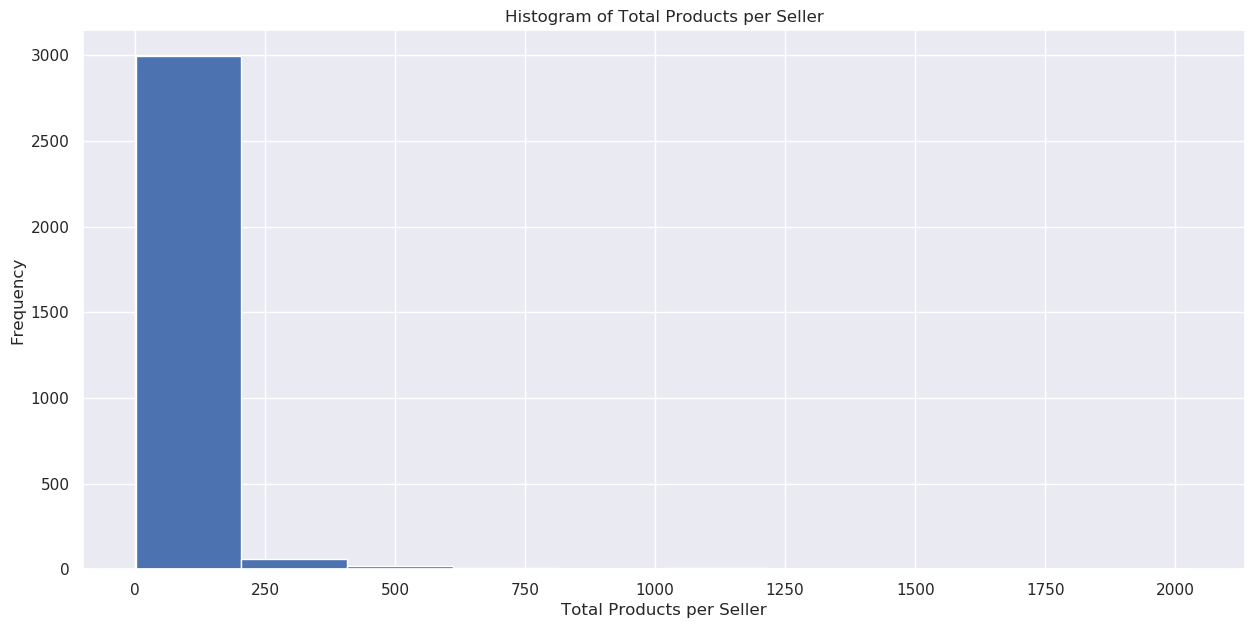

In [254]:
# How many products per seller?
seller_products = items_df.groupby(['seller_id']).count().reset_index()
seller_products = pd.DataFrame(seller_products, columns = ['seller_id', 'product_id'])
seller_products.rename(columns = {'product_id':'Total Products per Seller'}, inplace = True)

# Plot histogram of total products per seller
plt.hist(seller_products['Total Products per Seller'], bins=10)
plt.xlabel('Total Products per Seller')
plt.ylabel('Frequency')
plt.title('Histogram of Total Products per Seller')
plt.show()

## payments_dataset

In [184]:
payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,"""3b18ad0839d6984800c3bee0d41eadcd""",1,credit_card,1,108.85
1,"""82eba8671de9a5c76c7f3edfcd993955""",1,boleto,1,51.01
2,f8db134d4ac3747d627adb962ec08f73,1,credit_card,1,88.74
3,"""9a870a0bd211f5dcb640562f09fb33e3""",1,credit_card,10,114.77
4,b74b01e1553f1129b7aa5c0b73016c62,1,voucher,1,12.88


In [95]:
# Total orders per payment type
num_payment_type=pd.DataFrame(payments_df.groupby(['payment_type'])['order_id'].count().reset_index())
num_payment_type

,payment_type,order_id
0,boleto,19784
1,credit_card,76795
2,debit_card,1529
3,not_defined,3
4,voucher,5775


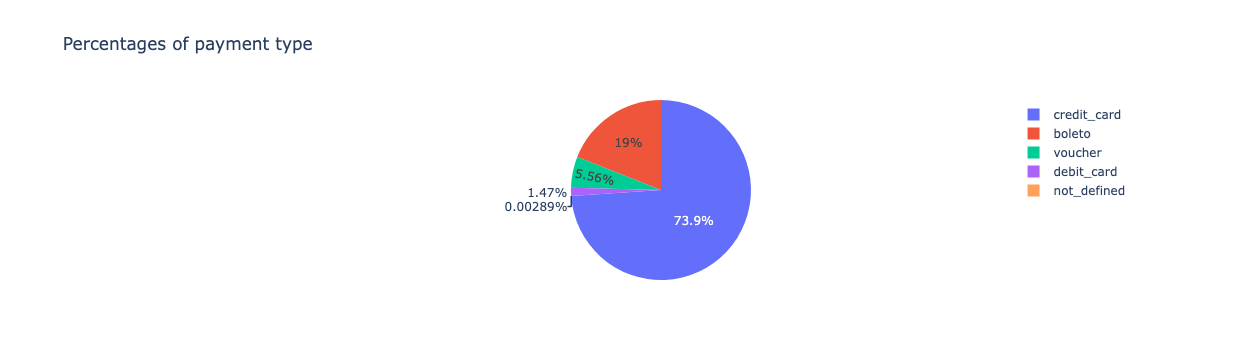

In [185]:
#Pie chart for percentage of each payment type
fig=px.pie(num_payment_type,values=num_payment_type['order_id'],names='payment_type',title='Percentages of payment type')
fig.show()

In [186]:
# Total payments per payment type 
payments_df.groupby(['payment_type'])['payment_value'].sum().reset_index()

,payment_type,payment_value
0,boleto,2869361.27
1,credit_card,12542084.19
2,debit_card,217989.79
3,not_defined,0.00
4,voucher,379436.87


In [187]:
#boxplot for payment_value
payments_df[['payment_value']].boxplot(vert=False)

In [188]:
# Average number of payment installments per payment type 
payments_df.groupby(['payment_type'])['payment_installments'].mean().reset_index()

,payment_type,payment_installments
0,boleto,1.000000
1,credit_card,3.507155
2,debit_card,1.000000
3,not_defined,1.000000
4,voucher,1.000000


## reviews_dataset

In [189]:
reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [190]:
reviews_df.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [ ]:
reviews_df = reviews_df.dropna()
reviews_df.shape

(9839, 7)

In [192]:
# Total orders per payment type, clearly need to balance this before we train on it
review_scores = pd.DataFrame(reviews_df.groupby(['review_score'])['order_id'].count().reset_index())
plt.bar(review_scores['review_score'], review_scores['order_id'])

<BarContainer object of 5 artists>

## orders_dataset

In [193]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [238]:
# Feature Engineering -  create new column for days late

orders_df2= orders_df.loc[(orders_df['order_status']=='delivered')] # drop rows of non-delivered data 

# drop unneeded columns 
orders_df2 = orders_df2.drop(columns = [
    'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date'])

# create date time from strings 
orders_df2['order_delivered_customer_date'] = (
    pd.to_datetime(orders_df2['order_delivered_customer_date'])).dt.date # drop timestamp
orders_df2['order_estimated_delivery_date'] = (
    pd.to_datetime(orders_df2['order_estimated_delivery_date'])).dt.date

# Create new column 
orders_df2['days_late'] = (orders_df2['order_delivered_customer_date'] - 
                           orders_df2['order_estimated_delivery_date']) # need this to be integer value 

# Drop columns used in feature engineering 
#orders_df2 = orders_df2.drop(columns = ['order_estimated_delivery_date', 'order_delivered_customer_date'])

orders_df2.head()

,order_id,customer_id,order_delivered_customer_date,order_estimated_delivery_date,days_late
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-10,2017-10-18,-8 days
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-08-07,2018-08-13,-6 days
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-17,2018-09-04,-18 days
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-12-02,2017-12-15,-13 days
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-16,2018-02-26,-10 days


## products_dataset

In [121]:
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm
0,"""1e9e8ef04dbcff4541ed26657ea517e5""",perfumaria,40.0,287.0,1.0,225.0,16.0
1,"""3aa071139cb16b67ca9e5dea641aaa2f""",artes,44.0,276.0,1.0,1000.0,30.0
2,"""96bd76ec8810374ed1b65e291975717f""",esporte_lazer,46.0,250.0,1.0,154.0,18.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0
4,"""9dc1a7de274444849c219cff195d0b71""",utilidades_domesticas,37.0,402.0,4.0,625.0,20.0


In [196]:
# How many product categories? How many products per category? 
product_categories = products_df.product_category_name.value_counts().reset_index()

# renaming categories 
product_categories.rename(columns={'index': 'product_category', 'product_category_name': 'no_products'}, inplace=True)

# Saving top X amount to dataframe for visualization 
product_categories_top_list = product_categories.head(20)

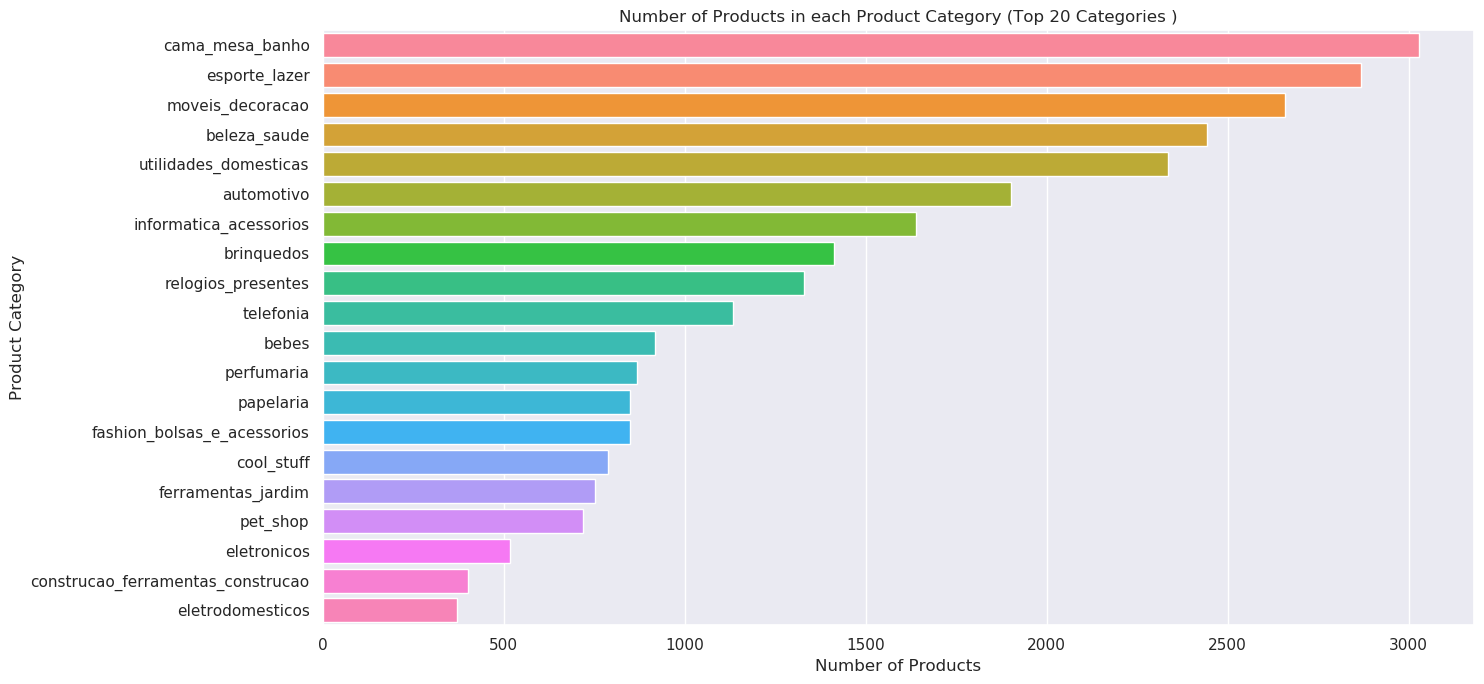

In [198]:
# Create plot
barplot = sns.barplot(y="product_category", x="no_products", data=product_categories_top_list, saturation=1)

# Set title and x-axis ticks
plt.title("Number of Products in each Product Category (Top 20 Categories )")

# Helper code to show actual values afters bars
#show_values_barplot(barplot, 0.1)

plt.xlabel("Number of Products")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show(barplot)

## sellers_dataset

In [199]:
sellers_df.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [200]:
# Number of sellers per city
pd.DataFrame(sellers_df.groupby(['seller_city'])['seller_id'].count().reset_index())

,seller_city,seller_id
0,04482255,1
1,abadia de goias,1
2,afonso claudio,1
3,aguas claras df,1
4,alambari,1
...,...,...
606,volta redonda,2
607,votorantim,4
608,votuporanga,4
609,xanxere,2


In [201]:
# Number of seller per state
pd.DataFrame(sellers_df.groupby(['seller_state'])['seller_id'].count().reset_index())

,seller_state,seller_id
0,AC,1
1,AM,1
2,BA,19
3,CE,13
4,DF,30
5,ES,23
6,GO,40
7,MA,1
8,MG,244
9,MS,5


In [202]:
sns.countplot(sellers_df['seller_state'])

## category_name_translation_data

In [203]:
translation_df.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [205]:
# get product id match to product category
ordered_products = orders_df2.merge(items_df,left_on = 'order_id',right_on = 'order_id',how = 'inner'
).merge(
    products_df,
    left_on='product_id',
    right_on='product_id',
    how='inner'
).merge(
    translation_df,
    left_on='product_category_name',
    right_on='product_category_name',
    how='inner'
)

In [207]:
#Count all the product items
top_products = ordered_products[['product_category_name_english']].value_counts().reset_index().rename(columns={0:'count'})
top_products

,product_category_name_english,count
0,bed_bath_table,10953
1,health_beauty,9465
2,sports_leisure,8431
3,furniture_decor,8160
4,computers_accessories,7644
...,...,...
66,arts_and_craftmanship,24
67,la_cuisine,14
68,cds_dvds_musicals,14
69,fashion_childrens_clothes,7


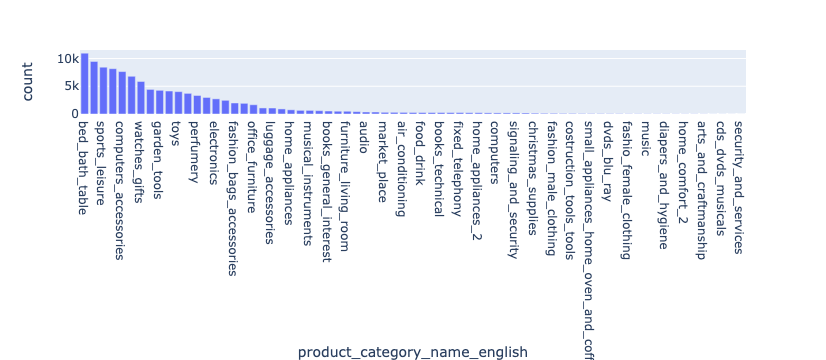

In [209]:
# bar chart for all product items selling number
fig = px.bar(top_products,x='product_category_name_english', y='count')
fig.show()

In [210]:
# count top 10 product items
top10_products = ordered_products[['product_category_name_english']].value_counts()[:10].reset_index().rename(columns={0:'count'})
top10_products

,product_category_name_english,count
0,bed_bath_table,10953
1,health_beauty,9465
2,sports_leisure,8431
3,furniture_decor,8160
4,computers_accessories,7644
5,housewares,6795
6,watches_gifts,5859
7,telephony,4430
8,garden_tools,4268
9,auto,4140


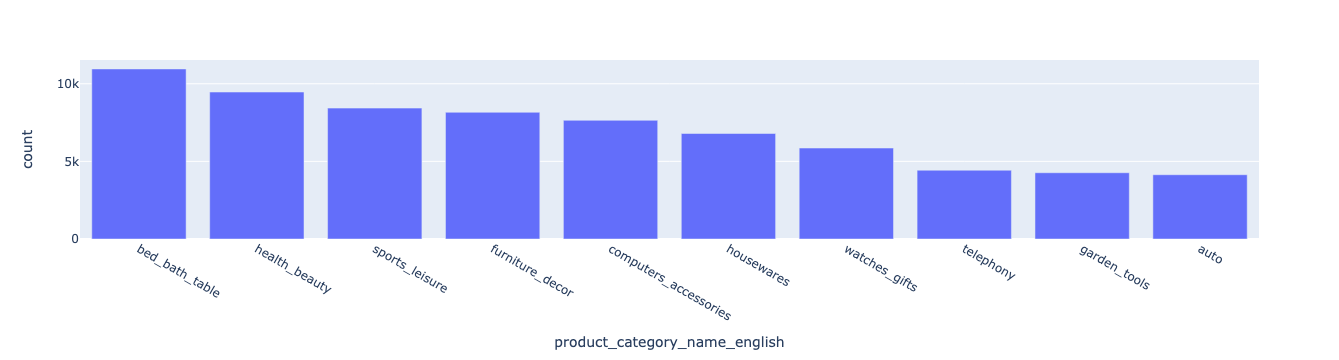

In [211]:
# Top 10 product items
fig = px.bar(top10_products,x='product_category_name_english', y='count')
fig.show()

## Data Schema Overview 

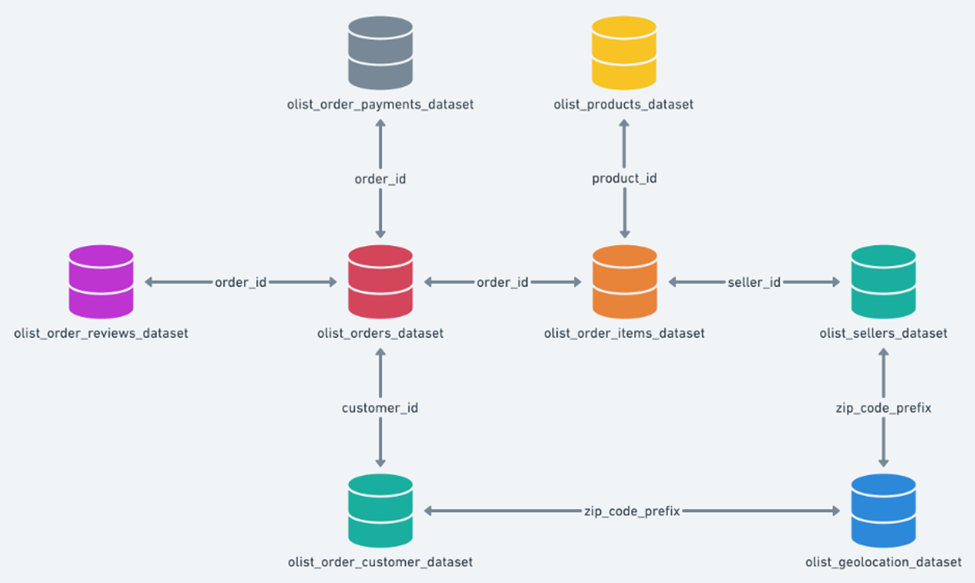

In [ ]:
# Get product category translation
products_translated_df = translation_df.merge(products_df, on='product_category_name', how='left')
products_translated_df.drop(products_translated_df.columns[[0]], axis=1, inplace=True)#### Merging the datasets

In [ ]:
# Get product category translation
products_translated_df = translation_df.merge(products_df, on='product_category_name', how='left')
products_translated_df.drop(products_translated_df.columns[[0]], axis=1, inplace=True)

In [217]:
# Get product category translation
merged_df = orders_df.merge(items_df, on='order_id', how='left')
merged_df = merged_df.merge(order_payments_df, on='order_id', how='outer', validate='m:m')
merged_df = merged_df.merge(reviews_df, on='order_id', how='outer')
merged_df = merged_df.merge(customers_df, on='customer_id', how='outer')
merged_df = merged_df.merge(sellers_df, on='seller_id', how='outer')
merged_df = merged_df.merge(products_translated_df, on='product_id', how='outer')

#### Display shape of the dataset, along with all field names and their respective datatypes, number of missing values, number of unique values, first value in the dataset, and feature entropy.

In [222]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def data_types(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]

    return summary

resumetable(merged_df)

Dataset Shape: (118446, 39)


,Name,dtypes,Missing,Uniques,First Value,Entropy
0,order_id,object,0,99441,e481f51cbdc54678b7cc49136f2d6af7,16.46
1,customer_id,object,0,99441,9ef432eb6251297304e76186b10a928d,16.46
2,order_status,object,0,8,delivered,0.25
3,order_purchase_timestamp,object,0,98875,2017-10-02 10:56:33,16.45
4,order_approved_at,object,176,90733,2017-10-02 11:07:15,16.28
5,order_delivered_carrier_date,object,2074,81018,2017-10-04 19:55:00,16.03
6,order_delivered_customer_date,object,3397,95664,2017-10-10 21:25:13,16.40
7,order_estimated_delivery_date,object,0,459,2017-10-18 00:00:00,8.47
8,order_item_id,float64,830,21,1.0,0.72
9,product_id,object,830,32951,87285b34884572647811a353c7ac498a,13.63


# Data Cleaning

In [223]:
# Need to convert datetime features to the correct format

show_original_dtypes = data_types(merged_df)

merged_df.order_purchase_timestamp = pd.to_datetime(merged_df.order_purchase_timestamp)
merged_df.order_approved_at = pd.to_datetime(merged_df.order_approved_at)
merged_df.order_delivered_carrier_date = pd.to_datetime(merged_df.order_delivered_carrier_date)
merged_df.order_estimated_delivery_date = pd.to_datetime(merged_df.order_estimated_delivery_date)
merged_df.order_delivered_customer_date = pd.to_datetime(merged_df.order_delivered_customer_date)
merged_df.review_creation_date = pd.to_datetime(merged_df.review_creation_date)
merged_df.review_answer_timestamp = pd.to_datetime(merged_df.review_answer_timestamp)
merged_df.shipping_limit_date = pd.to_datetime(merged_df.shipping_limit_date)

# Show/validate changed data types
show_new_dtypes = data_types(merged_df)
compare_dtypes = show_original_dtypes.merge(show_new_dtypes, on='Name', how='outer')
different_dtypes = compare_dtypes[compare_dtypes['dtypes_x'] != compare_dtypes['dtypes_y']]
different_dtypes

Dataset Shape: (118446, 39)
Dataset Shape: (118446, 39)


,Name,dtypes_x,dtypes_y
3,order_purchase_timestamp,object,datetime64[ns]
4,order_approved_at,object,datetime64[ns]
5,order_delivered_carrier_date,object,datetime64[ns]
6,order_delivered_customer_date,object,datetime64[ns]
7,order_estimated_delivery_date,object,datetime64[ns]
11,shipping_limit_date,object,datetime64[ns]
22,review_creation_date,object,datetime64[ns]
23,review_answer_timestamp,object,datetime64[ns]


#### What is the average review (1-5 stars) for each product category

In [239]:
# creating an aggregation
avg_score_per_category = merged_df.groupby('product_category_name_english', as_index=False).agg({'review_score': ['count', 'mean']})
avg_score_per_category.columns = ['product_category_name_english', 'count', 'mean']

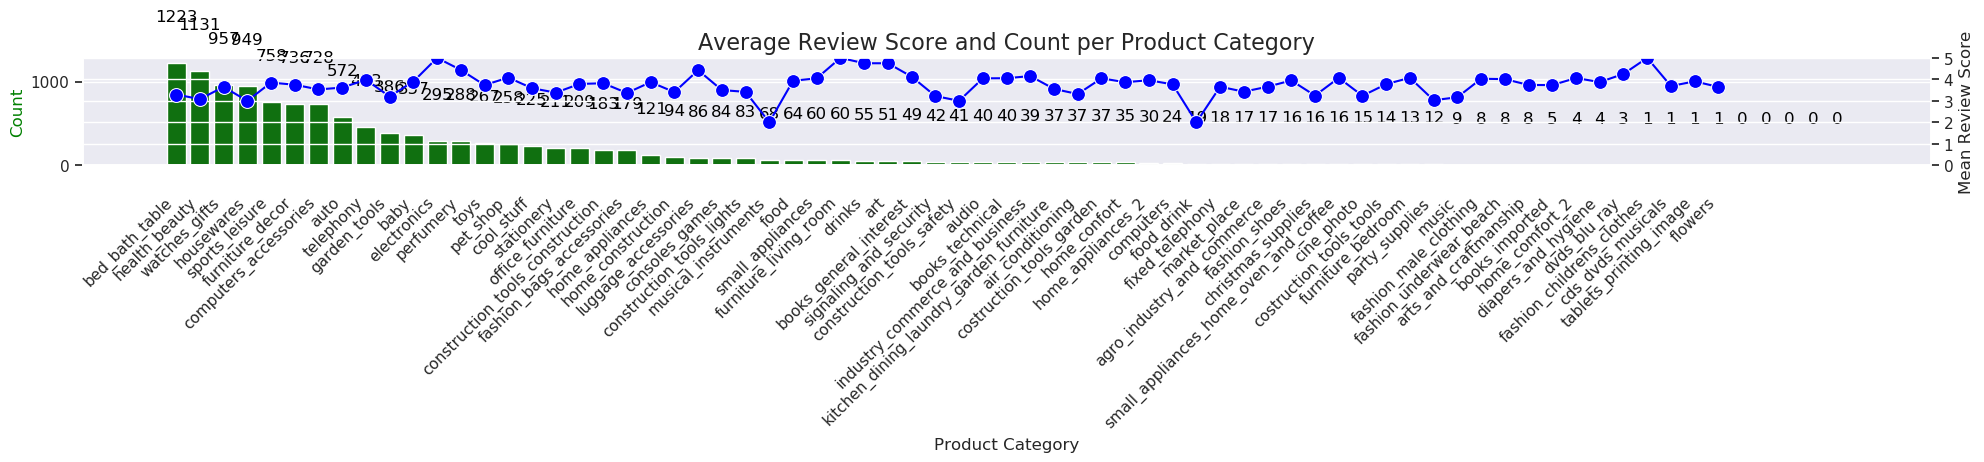

In [247]:
# sort the dataframe by mean review score in descending order
avg_score_per_category = avg_score_per_category.sort_values('count', ascending=False)

# create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(20, 6))
ax2 = ax1.twinx()

# create the bar plots for counts and mean
sns.barplot(x='product_category_name_english', y='count', data=avg_score_per_category, color='green', ax=ax1)
sns.lineplot(x='product_category_name_english', y='mean', data=avg_score_per_category, color='blue', marker='o', markersize=10, ax=ax2)

# add count labels on top of the bars
for i, v in enumerate(avg_score_per_category['count']):
    ax1.text(i, v + 500, str(v), color='black', ha='center')

# set the y-axis labels and tick labels
ax1.set_ylabel('Count', color='green')
ax2.set_ylabel('Mean Review Score')
ax1.set_yticks(range(0, max(avg_score_per_category['count'])+1, 1000))
ax2.set_yticks(range(0, 6))
ax2.set_ylim(0, 5)

# set the x-axis labels and tick labels
ax1.set_xlabel('Product Category')
ax1.set_xticklabels(avg_score_per_category['product_category_name_english'], rotation=45, ha='right')

# adjust the position and angle of the x-tick labels
ax1.tick_params(axis='x', which='major', pad=15, rotation=45)

# add titles
ax1.set_title('Average Review Score and Count per Product Category', fontsize=16)

plt.tight_layout()
plt.show()

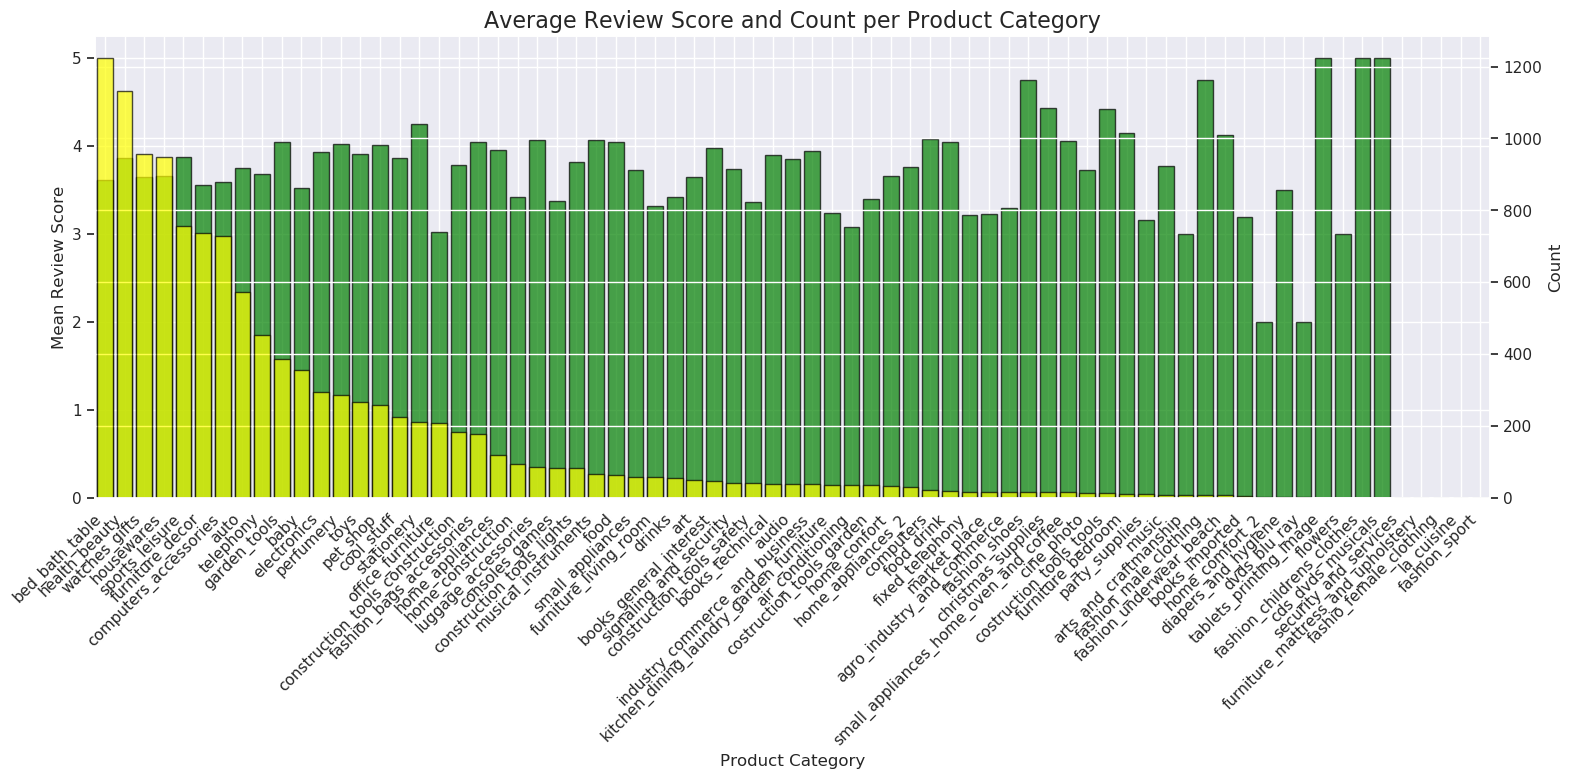

In [241]:
# sort the dataframe by mean review score in descending order
avg_score_per_category = avg_score_per_category.sort_values('count', ascending=False)

# create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(18, 6))
ax2 = ax1.twinx()

# create the first bar for mean review score
ax1.bar(avg_score_per_category['product_category_name_english'], avg_score_per_category['mean'], color='green', alpha=0.7, edgecolor='black')
ax1.set_ylabel('Mean Review Score', fontsize=12)

# create the second bar for count
ax2.bar(avg_score_per_category['product_category_name_english'], avg_score_per_category['count'], color='yellow', alpha=0.7, edgecolor='black')
ax2.set_ylabel('Count', fontsize=12)

# add titles and labels
ax1.set_title('Average Review Score and Count per Product Category', fontsize=16)
ax1.set_xlabel('Product Category', fontsize=12)

# rotate and space out x-axis labels
ax1.set_xticklabels(avg_score_per_category['product_category_name_english'], rotation=45, ha='right')
ax1.set_xlim(-0.5, len(avg_score_per_category) - 0.5)

# display the plot
plt.show()

# Model Training 

In [280]:
# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"
VOCAB_SIZE = 10000
MAX_LENGTH = 120
MAX_ITER = 10000
N_JOBS = 4
N_NEIGHBORS = 5
N_ESTIMATORS = 50
MAX_DEPTH = 1

In [271]:
data = pd.read_csv(r'data/olist_order_reviews_dataset.csv') 

In [4]:
# columns_to_keep = ['review_score', 'review_comment_message']
# data_drop = data.drop(columns=[col for col in data.columns if col not in columns_to_keep])
# data_drop

# data_drop_nans = data_drop.dropna(subset=['review_comment_message'])
# nan_counts = data_drop_nans.isnull().sum()
# print(nan_counts)
# data_drop_nans

In [272]:
def clean_data(data, column_text='review_comment_message', 
               column_score='review_score', 
               points_cut = [0, 2, 5], 
               classes = [0, 1]):
    
    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text','label']]
    
    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text' , column_score: 'label'})
    df_cat = df_cat[['text','label']]
    return df_bin ,df_cat

data_bin , data_cat = clean_data(data)

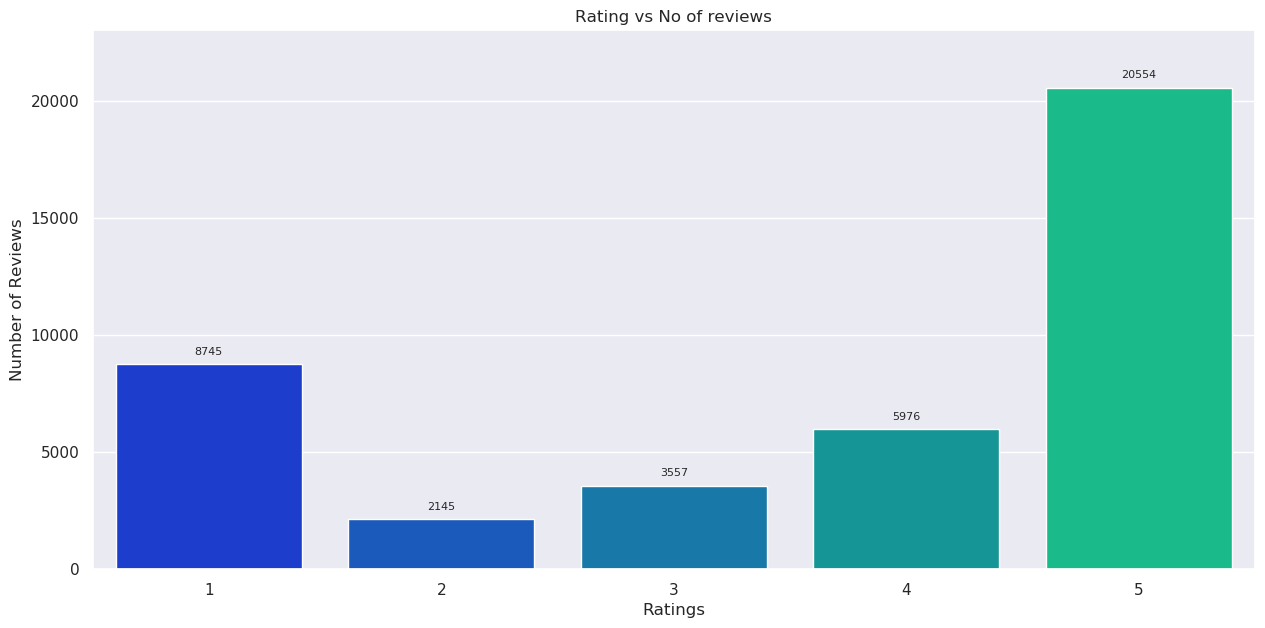

In [273]:
ax = sns.countplot(x=data_cat['label'], palette='winter')
plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.title('Rating vs No of reviews')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=8)
ax.set_ylim(0, 23000)  # Set the y-axis limit to 0 and 5000

plt.show()

# WORDCLOUD

In [ ]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(data_bin["text"]))

fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [105]:
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


all data
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for index, train in df_train.iterrows():
        X_train.append(str(train['text']))
        y_train.append(train['label'])

    for index, test in df_test.iterrows():
        X_test.append(str(test['text']))
        y_test.append(test['label'])

    y_train = np.array(y_train)
    y_test = np.array(y_test) 

    return X_train , y_train , X_test , y_test

X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [281]:
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    # Separate majority and minority classes
    df_majority = data[data['label']==0]
    df_minority = data[data['label']==1]

    # Undersample majority class
    n_samples = min(len(df_majority), len(df_minority))
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,    # sample without replacement
                                       n_samples=n_samples, # match minority class
                                       random_state=random_state)

    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Split into train and test sets
    df_train = df_balanced.sample(frac=split_train, random_state=random_state)
    df_test = df_balanced.drop(df_train.index)

    X_train = df_train['text'].tolist()
    y_train = df_train['label'].values
    X_test = df_test['text'].tolist()
    y_test = df_test['label'].values

    return X_train , y_train , X_test , y_test

X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [282]:
# Import the Tokenizer class from the keras.preprocessing.text module and instantiate an object with specified parameters.
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)

# Fit the tokenizer on the training set, creating a word index based on the frequency of occurrence of each word in the corpus.
tokenizer.fit_on_texts(X_train)

# Define a function to preprocess the text data by converting each sentence into a sequence of integers using the fitted tokenizer and padding/truncating them to a fixed length.
def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):

    # Convert each sentence in the training set to a sequence of integers using the fitted tokenizer.
    training_sequences = tokenizer.texts_to_sequences(X_train)

    # Pad the sequences to a fixed length by adding zeros or truncating from the beginning or end based on the trunc_type parameter.
    X_train_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

    # Convert each sentence in the test set to a sequence of integers using the fitted tokenizer.
    testing_sequences = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to a fixed length without truncation since the test set should not be modified.
    X_test_padded = pad_sequences(testing_sequences,maxlen=max_length)

    # Return the padded training and test sets as output of the function.
    return X_train_padded, X_test_padded

# Call the preprocess function on the training and test sets to obtain padded and processed data.
X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)

In [283]:
%%time
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", nb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  74.48904886828137 %
Model score on Testing Data =  74.37461866992068 %
CPU times: user 98.1 ms, sys: 96.8 ms, total: 195 ms
Wall time: 169 ms


In [284]:
%%time
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

Model score on Training Data =  74.3883838691965 %
Model score on Testing Data =  73.91092129347163 %
CPU times: user 84.1 ms, sys: 267 ms, total: 351 ms
Wall time: 41.4 s


In [22]:
%%time
svm = SVC(random_state=RANDOM_STATE , verbose = True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", svm.score(X_test,y_test)*100 ,"%")

[LibSVM]Model score on Training Data =  79.7907388200842 %
Model score on Testing Data =  74.49664429530202 %
Wall time: 6min 7s


In [23]:
%%time
rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", rfc.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  99.5790372765542 %
Model score on Testing Data =  78.40146430750458 %
Wall time: 3.35 s


In [24]:
%%time
xgb = XGBClassifier(objective='binary:logistic' , 
                    use_label_encoder=False,  
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  92.96870233664816 %
Model score on Testing Data =  83.01403294691885 %
Wall time: 8.33 s


In [65]:
%%time
ada_clf = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_clf.fit(X_train, y_train)
ada_preds = ada_clf.predict(X_test)
print("Model score on Training Data = ", ada_clf.score(X_train, y_train)*100 ,"%")
print("Model score on Testing Data = ", ada_clf.score(X_test, y_test)*100 ,"%")

Model score on Training Data =  76.68537612104204 %
Model score on Testing Data =  76.57107992678462 %
Wall time: 8.02 s


In [69]:
%%time
knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
print("Model score on Training Data = ", knn.score(X_train, y_train) * 100, "%")
print("Model score on Testing Data = ", knn.score(X_test, y_test) * 100, "%")

Model score on Training Data =  81.0841315355988 %
Model score on Testing Data =  73.48383160463698 %
Wall time: 42.7 s


In [71]:
%%time
mlp = MLPClassifier(random_state=RANDOM_STATE, verbose=True)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)
print("Model score on Training Data = ", mlp.score(X_train, y_train) * 100, "%")
print("Model score on Testing Data = ", mlp.score(X_test, y_test) * 100, "%")

Iteration 1, loss = 6.28942225
Iteration 2, loss = 4.63893484
Iteration 3, loss = 4.07533070
Iteration 4, loss = 3.70192929
Iteration 5, loss = 3.37079442
Iteration 6, loss = 3.13457185
Iteration 7, loss = 2.94181539
Iteration 8, loss = 2.70897191
Iteration 9, loss = 2.44960553
Iteration 10, loss = 2.40813811
Iteration 11, loss = 2.22020746
Iteration 12, loss = 2.11740944
Iteration 13, loss = 2.11616636
Iteration 14, loss = 1.83439109
Iteration 15, loss = 1.83869359
Iteration 16, loss = 1.69616780
Iteration 17, loss = 1.61867734
Iteration 18, loss = 1.50444388
Iteration 19, loss = 1.45344201
Iteration 20, loss = 1.36810405
Iteration 21, loss = 1.31395413
Iteration 22, loss = 1.24084145
Iteration 23, loss = 1.21917707
Iteration 24, loss = 1.19692482
Iteration 25, loss = 1.06976269
Iteration 26, loss = 1.05818051
Iteration 27, loss = 0.98085750
Iteration 28, loss = 0.97997374
Iteration 29, loss = 0.96453634
Iteration 30, loss = 0.89408494
Iteration 31, loss = 0.87813042
Iteration 32, los

In [78]:
%%time
sgd = SGDClassifier(random_state=RANDOM_STATE, verbose=True)
sgd.fit(X_train, y_train)
sgd_preds = sgd.predict(X_test)
print("Model score on Training Data = ", sgd.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", sgd.score(X_test,y_test)*100 ,"%")

-- Epoch 1
Norm: 8624.00, NNZs: 44, Bias: 2949.373976, T: 32782, Avg. loss: 4380590.436975
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 5228.62, NNZs: 44, Bias: 3499.473424, T: 65564, Avg. loss: 839657.207237
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 3368.63, NNZs: 44, Bias: 3778.598499, T: 98346, Avg. loss: 493022.438748
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 2162.69, NNZs: 44, Bias: 3970.242287, T: 131128, Avg. loss: 350318.501785
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1907.67, NNZs: 44, Bias: 4106.120713, T: 163910, Avg. loss: 277939.860216
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1788.42, NNZs: 44, Bias: 4215.080207, T: 196692, Avg. loss: 223456.194828
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1577.72, NNZs: 44, Bias: 4296.365712, T: 229474, Avg. loss: 189836.524264
Total training time: 0.09 seconds.
-- Epoch 8
Norm: 1487.59, NNZs: 44, Bias: 4365.231512, T: 262256, Avg. loss: 159464.110714
Total training time: 0.10 sec

# Confusion Matrices

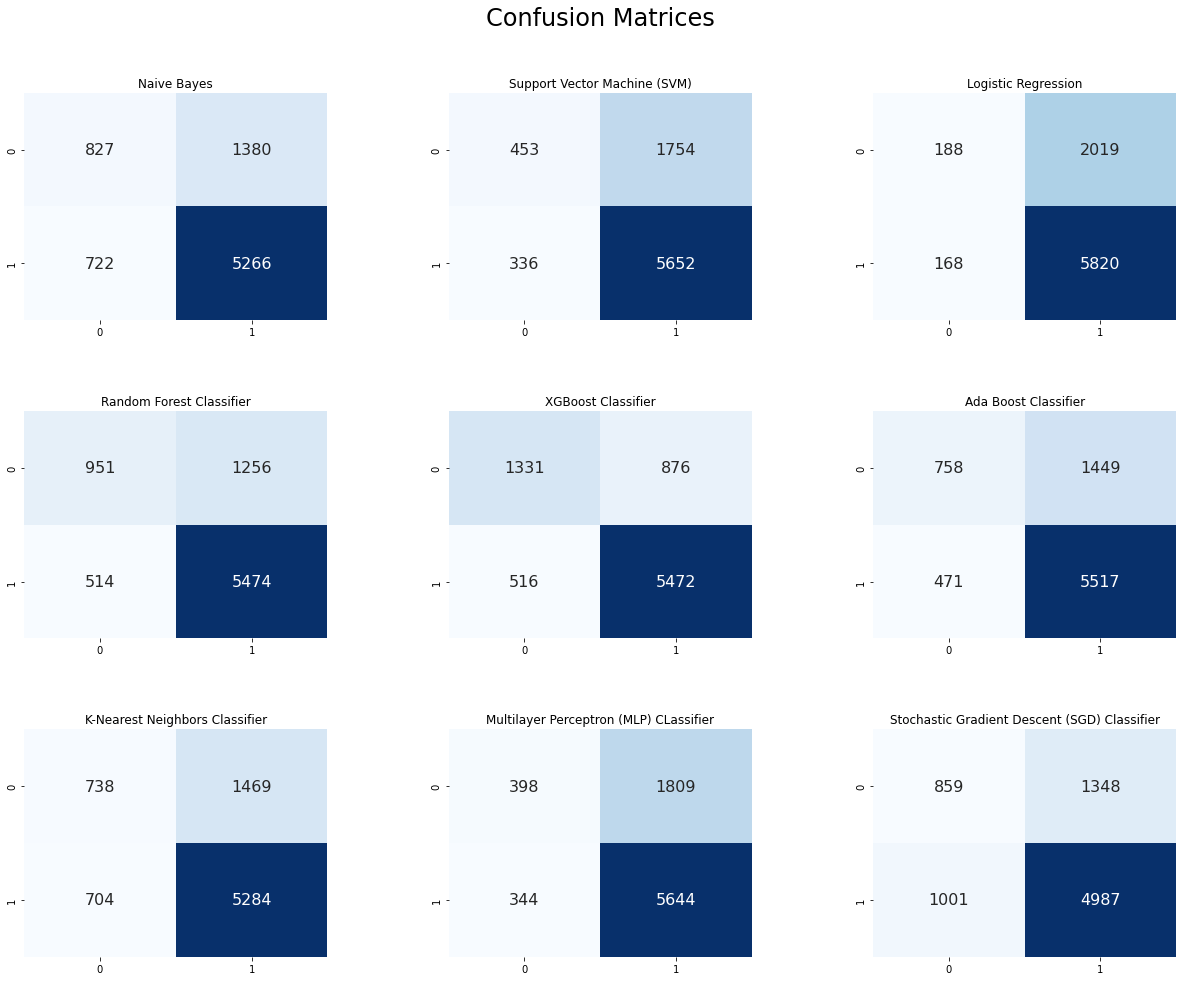

In [84]:
lr_cm=confusion_matrix(y_test, lr_preds )
nb_cm=confusion_matrix(y_test, nb_preds)
svm_cm=confusion_matrix(y_test, sv_preds)
sgd_cm= confusion_matrix(y_test,sgd_preds)
rf_cm = confusion_matrix(y_test,rf_preds)
xg_cm = confusion_matrix(y_test,xg_preds)
ada_cm = confusion_matrix(y_test,ada_preds)
knn_cm = confusion_matrix(y_test,knn_preds)
mlp_cm = confusion_matrix(y_test,mlp_preds)
sgd_cm= confusion_matrix(y_test,sgd_preds)

# plt.figure(figsize=(20,15))
plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(3,3,1)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,2)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,3)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,4)
plt.title("Random Forest Classifier")
sns.heatmap(rf_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,5)
plt.title("XGBoost Classifier")
sns.heatmap(xg_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,6)
plt.title("Ada Boost Classifier")
sns.heatmap(ada_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,7)
plt.title("K-Nearest Neighbors Classifier")
sns.heatmap(knn_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,8)
plt.title("Multilayer Perceptron (MLP) CLassifier")
sns.heatmap(mlp_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,9)
plt.title("Stochastic Gradient Descent (SGD) Classifier")
sns.heatmap(sgd_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# ROC-AUC Curves Comparison

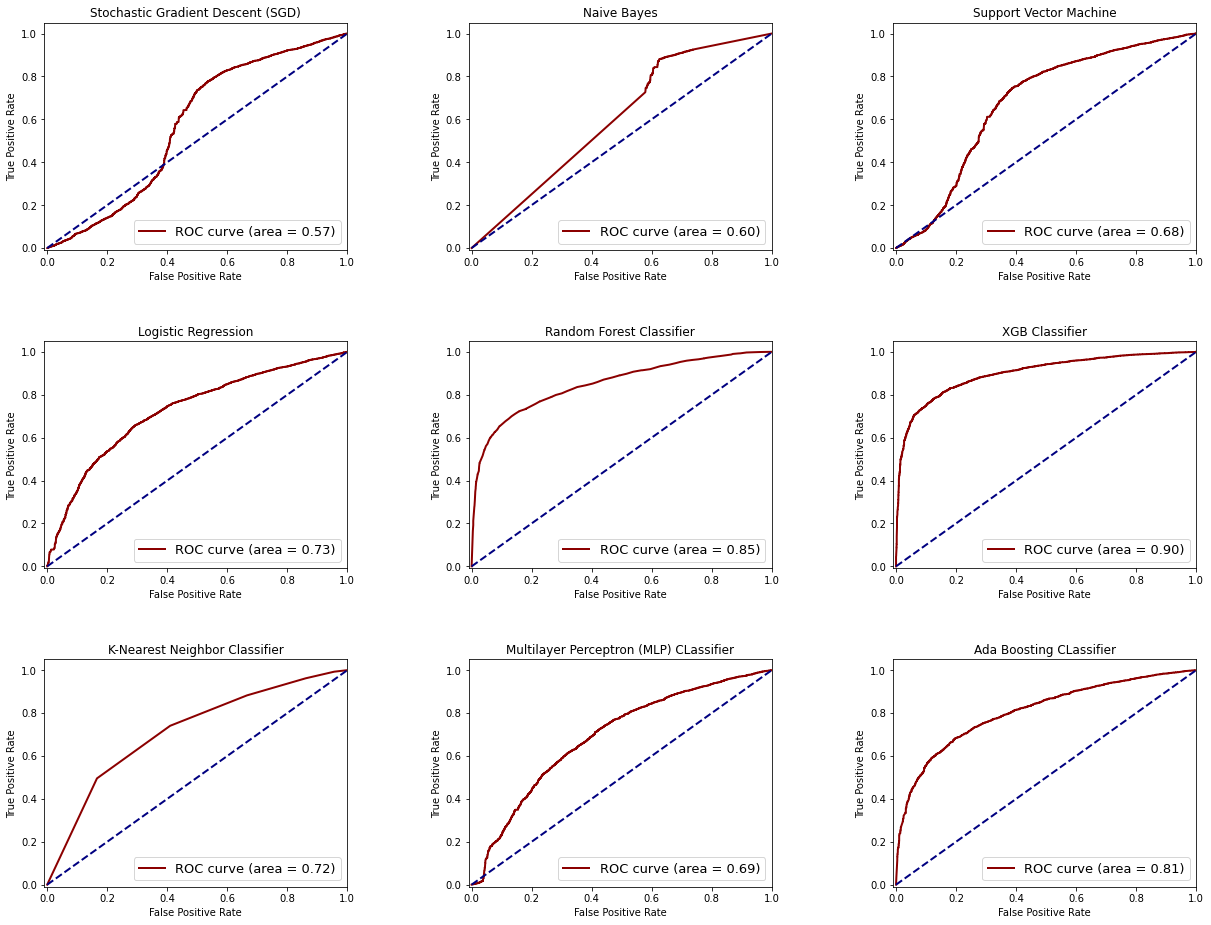

In [93]:
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_sgd = sgd.decision_function(X_test)
fpr_sgd,tpr_sgd,_ = roc_curve(y_test,pred_sgd)
roc_auc_sgd = auc(fpr_sgd,tpr_sgd)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

pred_knn = knn.predict_proba(X_test)[:,1]
fpr_knn,tpr_knn,_ = roc_curve(y_test,pred_knn)
roc_auc_knn = auc(fpr_knn,tpr_knn)

pred_mlp = mlp.predict_proba(X_test)[:,1]
fpr_mlp,tpr_mlp,_ = roc_curve(y_test,pred_mlp)
roc_auc_mlp = auc(fpr_mlp,tpr_mlp)

pred_ada = ada_clf.predict_proba(X_test)[:,1]
fpr_ada,tpr_ada,_ = roc_curve(y_test,pred_ada)
roc_auc_ada = auc(fpr_ada,tpr_ada)

f, axes = plt.subplots(3,3,figsize=(20,15))

axes[0,0].plot(fpr_sgd, tpr_sgd, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_sgd))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Stochastic Gradient Descent (SGD)')
axes[0,0].legend(loc='lower right', fontsize=13);

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[1,1].legend(loc='lower right', fontsize=13);

axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'XGB Classifier')
axes[1,2].legend(loc='lower right', fontsize=13);

axes[2,0].plot(fpr_knn, tpr_knn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_knn))
axes[2,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'K-Nearest Neighbor Classifier')
axes[2,0].legend(loc='lower right', fontsize=13);

axes[2,1].plot(fpr_mlp, tpr_mlp, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_mlp))
axes[2,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Multilayer Perceptron (MLP) CLassifier')
axes[2,1].legend(loc='lower right', fontsize=13);

axes[2,2].plot(fpr_ada, tpr_ada, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_ada))
axes[2,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Ada Boosting CLassifier')
axes[2,2].legend(loc='lower right', fontsize=13);

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

In [1]:
# Plot ROC curves for all algorithms
plt.figure(figsize=(10,8))
plt.plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='Logistic Regression (area = {:0.2f})'.format(roc_auc_lr))
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label='Naive Bayes (area = {:0.2f})'.format(roc_auc_nb))
plt.plot(fpr_sgd, tpr_sgd, color='green', lw=2, label='Stochastic Gradient Descent (SGD) (area = {:0.2f})'.format(roc_auc_sgd))
plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='Support Vector Machine (area = {:0.2f})'.format(roc_auc_svm))
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label='Random Forest (area = {:0.2f})'.format(roc_auc_rf))
plt.plot(fpr_xg, tpr_xg, color='brown', lw=2, label='XGBoost (area = {:0.2f})'.format(roc_auc_xg))
plt.plot(fpr_knn, tpr_knn, color='gray', lw=2, label='K-Nearest Neighbors (area = {:0.2f})'.format(roc_auc_knn))

NameError: name 'plt' is not defined

# Release Resources

In [ ]:
## Release Resources 
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>